In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tabulate import tabulate
import requests

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load Data

In [2]:
df_all = pd.read_csv('data/all_seasons_merged.csv')
df_all.head()

,name,position,team,xP,assists_x,bonus,bps,clean_sheets,creativity,element,...,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts,team_id,opp_team_id,pos_id,team_goals,opponent_goals
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,0.0,0.0,0.0,0.0,0.0,5,6,4,1.0,3.0
1,Aaron Cresswell,DEF,West Ham,2.1,0,0,11,0,11.2,435,...,0.0,0.0,0.0,0.0,0.0,19,15,2,0.0,2.0
2,Aaron Ramsdale,GK,Sheffield Utd,2.5,0,0,12,0,0.0,483,...,0.0,0.0,0.0,0.0,0.0,23,20,1,0.0,2.0
3,Abdoulaye Doucouré,MID,Everton,1.3,0,0,20,1,44.6,512,...,0.0,0.0,0.0,0.0,0.0,8,18,3,1.0,0.0
4,Aboubakar Kamara,MID,Fulham,0.4,0,0,-2,0,1.8,190,...,0.0,0.0,0.0,0.0,0.0,9,1,3,0.0,3.0


# Visualize Correlation Matrix of Data

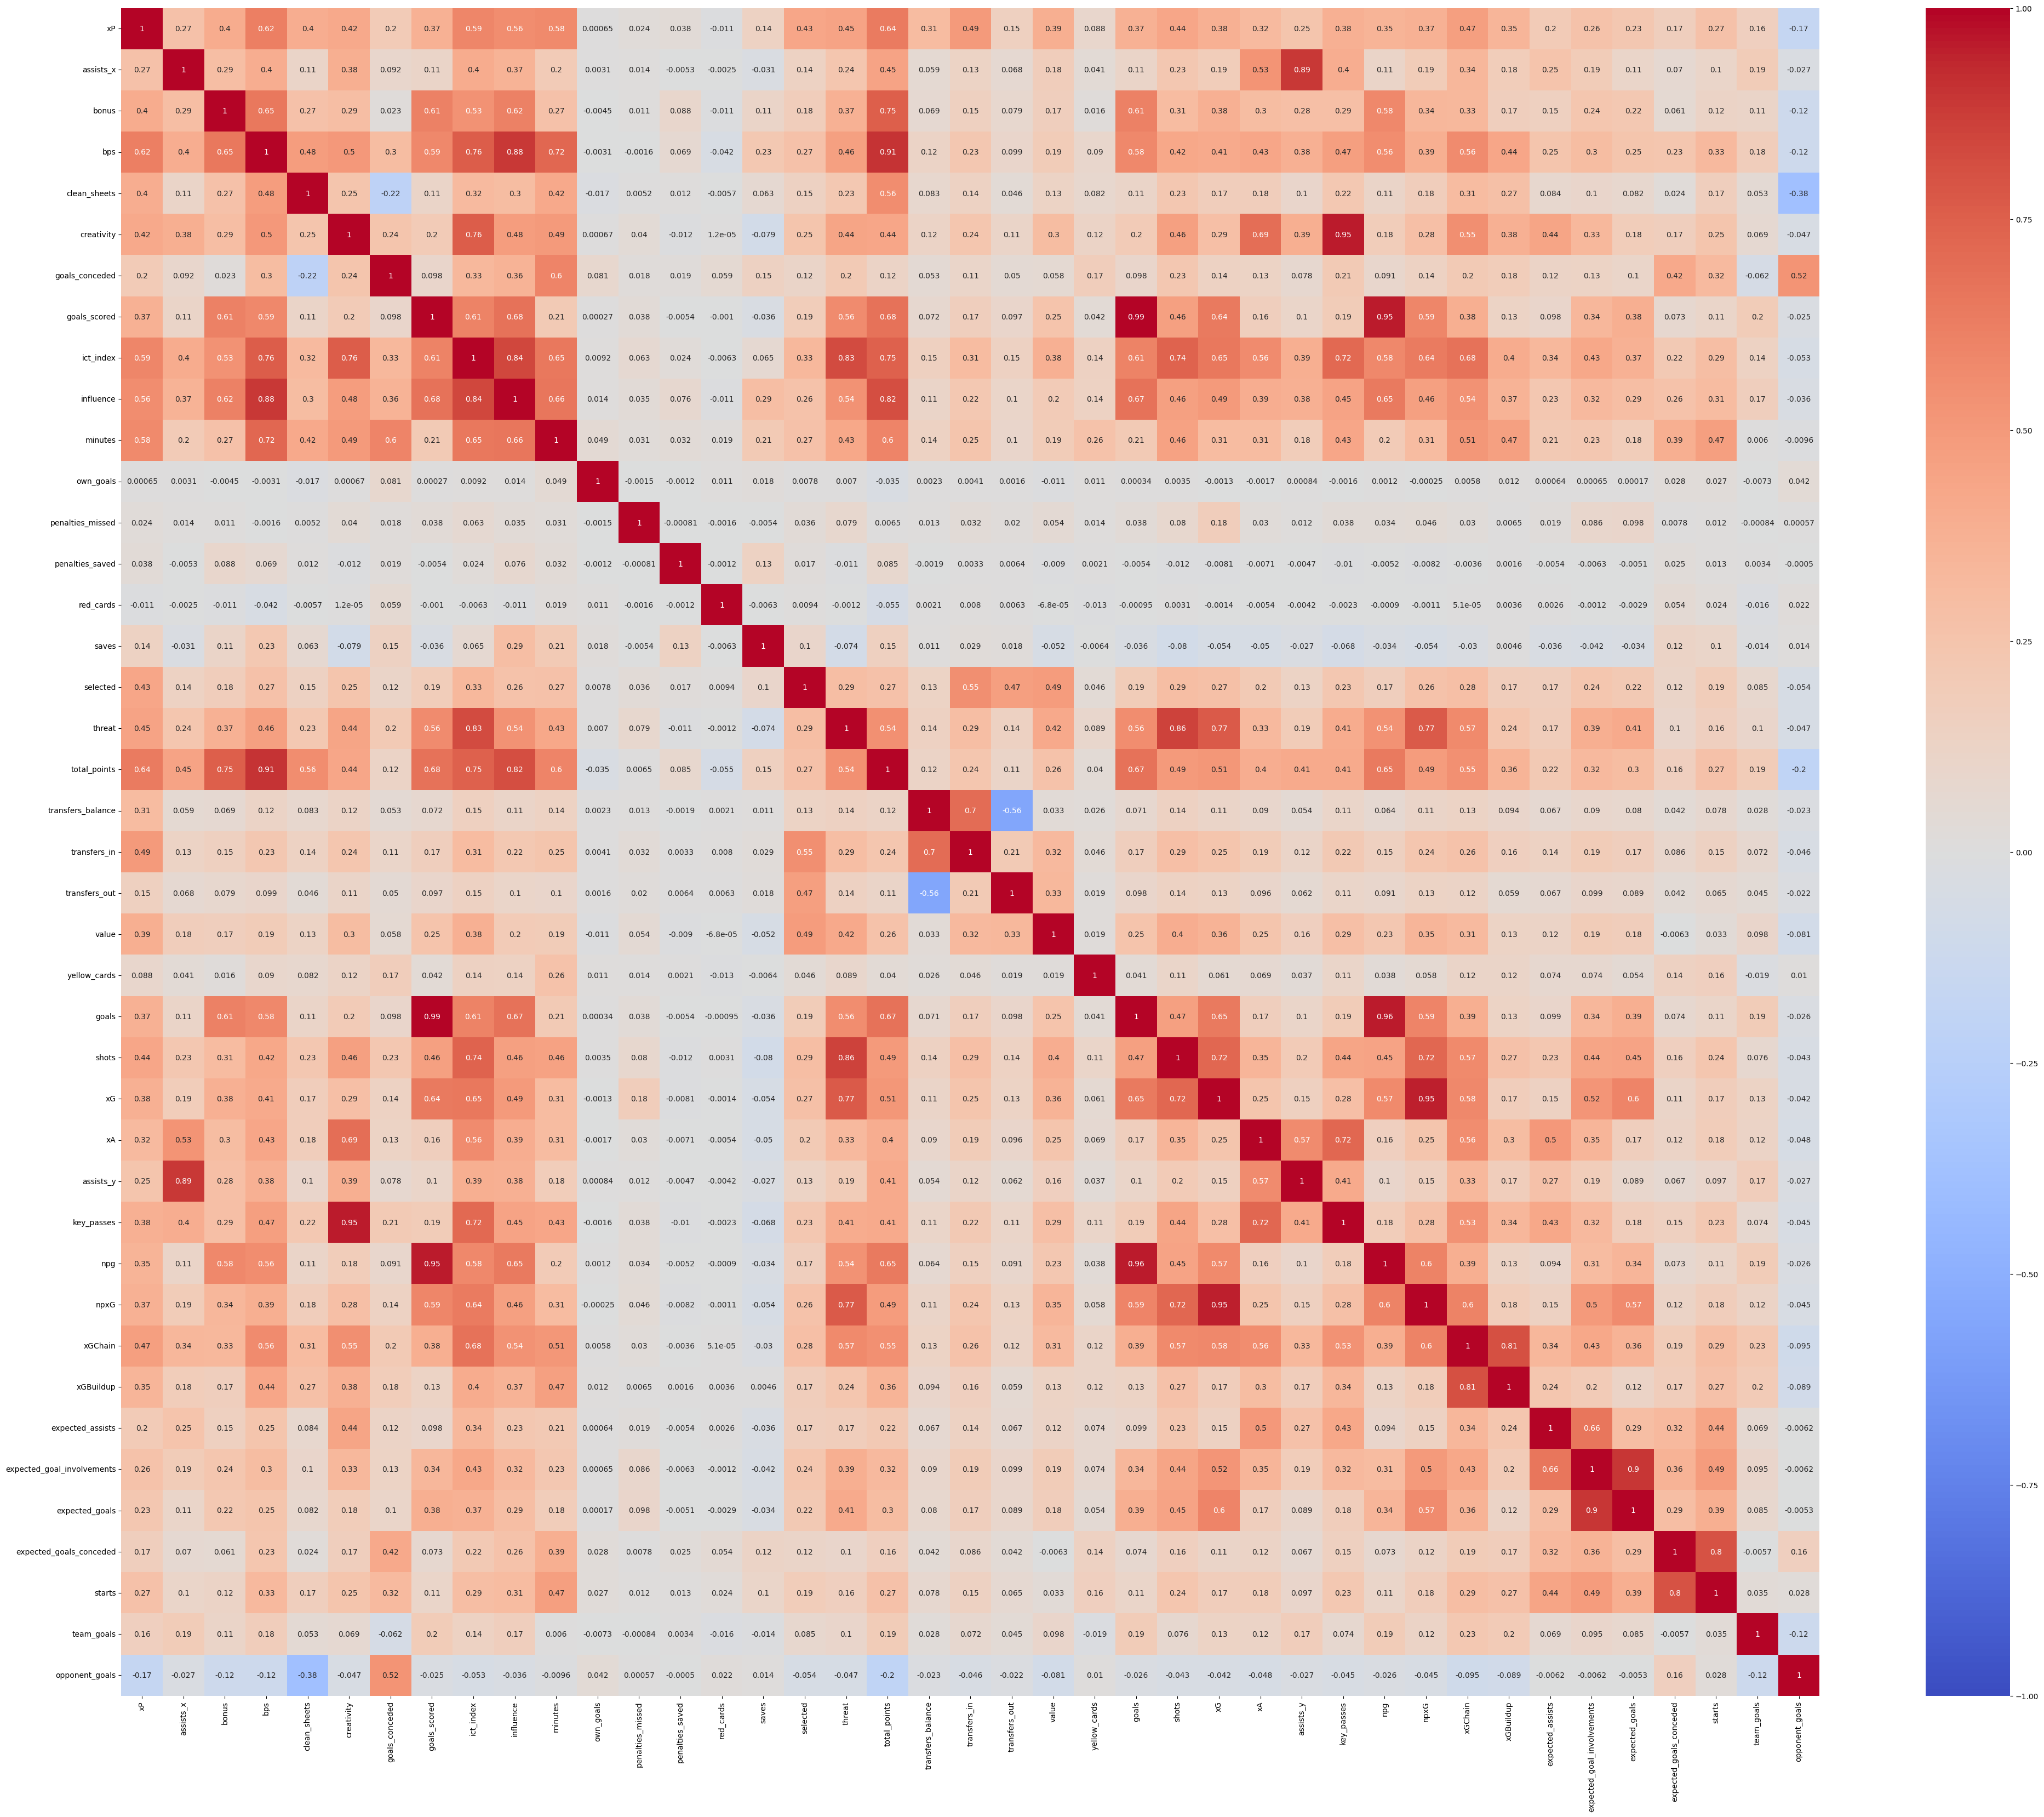

In [3]:
# Select only numeric columns
numeric_df = df_all.select_dtypes(include='number')

# List of columns to drop
columns_to_drop = [
    'element', 'fixture', 'round', 'GW', 'id',
    'season', 'roster_id', 'player_id', 'team_id', 'opp_team_id',
    'pos_id', 'time',
    
    'h_goals', 'a_goals', 'team_a_score', 'team_h_score',
    #, 'goals', 'expected_goal_involvements'
]

# Dropping the columns
numeric_df = numeric_df.drop(columns=columns_to_drop)

# All possible keys
keys_to_select = list(numeric_df.columns)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize Matrix
plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.savefig('correlation_matrix_heatmap.png')
plt.show()

In [5]:
# df_part = df_all[['name', 'kickoff_date', 'h_team', 'a_team', 'team', 'opponent_team', 'minutes', 'goals_scored', 'goals']]

# g1 = list(df_all.goals_scored)
# g2 = list(df_all.goals)

# count = 0
# count2 = 0
# count3 = 0

# for i in range(len(g1)):
#     if g1[i] > 0:
#         count2 += 1
#     if g2[i] > 0:
#         count3 += 1
#     if g1[i] != g2[i]:
#         count += 1
#         print(g1[i],g2[i])
#         print(df_part.iloc[i])

In [ ]:
# df_part[df_part.name == 'Gabriel Magalhães']

In [ ]:
# df_all[df_all.name == 'Gabriel Magalhães'].iloc[0][:20]

# Make Training Data

In [6]:
def one_hot_encode_team(team_id, num_teams=20):
    # Create a zero array of length num_teams
    one_hot = np.zeros(num_teams)
    
    # Set the correct index to 1 (team_id - 1 because team_id starts from 1)
    one_hot[team_id - 1] = 1
    
    return one_hot

In [7]:
keys_to_select = list(numeric_df.columns)

# keys_to_select = [
#     # Overall
#     'total_points',
#     'minutes',
#     'transfers_in',
#     'transfers_out',

#     # Attacking
#     'goals_scored',
#     'assists',
#     'shots',
#     'xG',
#     'xA',
#     'key_passes',
#     'npg',
#     'npxG',
#     'xGChain',
#     'xGBuildup',
#     'expected_assists',
#     'expected_goal_involvements',
#     'expected_goals',
    
#     # Defensive
#     'clean_sheets',
#     'goals_conceded',
#     'saves',
#     'penalties_saved',
#     'expected_goals_conceded',
#     'own_goals',
    
#     # Cards
#     'yellow_cards',
#     'red_cards',
    
#     # Penalties
#     'penalties_missed',
    
#     # Bonus and ICT
#     'bonus',
#     'bps',
#     'threat',
#     'influence',
#     'creativity',
# ]

In [ ]:
X = []
y = []
played = []

for player in df_all.name.unique():
    df_temp = df_all[df_all.name == player].copy()
    if len(df_temp) < 4:
        continue
    
    for i in range(3, len(df_temp)):
        
        # Select row for next game
        next_game = df_temp.iloc[i]
        
        if next_game['minutes']+df_temp.iloc[i-1]['minutes']+df_temp.iloc[i-2]['minutes']+df_temp.iloc[i-3]['minutes']==0:
            played.append(0)
        else:
            played.append(1)
        
        # Get one-hot encoding for players team, opp team, home/away and position
        player_team = one_hot_encode_team(next_game['team_id'], 27)
        opponent_team = one_hot_encode_team(next_game['opp_team_id'], 27)
        home_away = one_hot_encode_team(next_game['was_home'], 2)
        position = one_hot_encode_team(next_game['pos_id'], 4)
        
        # Combine into one vector
        combined_stats = np.concatenate([player_team, opponent_team, home_away, position])
        
        # Get points scored (y value)
        points = next_game['total_points']
        
        # Get player stats from previous games
        for j in range(1,4):
            row_temp = df_temp.iloc[i-j]
            
            # Get home/away encoding
            home_away = one_hot_encode_team(row_temp['was_home'], 2)
            
            # Add player team goals and opponent team goals
            if row_temp.was_home:
                score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
            else:
                score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)
            
            # Select the wanted stats and convert to float numpy array
            selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 
                
            # Combine into one vector
            combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])
            
        # Append combined stats to X and points (y value) to y
        X.append(combined_stats)
        y.append(points)

# Convert lists to numpy arrays for training/testing
X = np.array(X)
y = np.array(y)
played = np.array(played)

np.save('data/xgboost/X.npy', X)
np.save('data/xgboost/y.npy', y)
np.save('data/xgboost/played.npy', played)

print("Training data (X):", X.shape)
print("Target values (y):", y.shape)
print("Played values (y):", played.shape)

In [8]:
X = np.load('data/xgboost/X.npy')
y = np.load('data/xgboost/y.npy')
played = np.load('data/xgboost/played.npy')

print("Training data (X):", X.shape)
print("Target values (y):", y.shape)
print("Played values (y):", played.shape)

Training data (X): (99297, 195)
Target values (y): (99297,)
Played values (y): (99297,)


# Train model - XGBoost

### Data split and scaler

In [9]:
# Split the data into training and testing sets
y_clipped = np.clip(y, 0, 12)
X_train, X_val, y_train, y_val, played_train, played_val = train_test_split(X,y_clipped,played,test_size=0.2,random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# # Only select games where the player played within the last 3 games
# X_train_played = X_train[played_train==1]
# X_val_played = X_val[played_val==1]
# y_train_played = y_train[played_train==1]
# y_val_played = y_val[played_val==1]

# # Train model
# model_played = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model_played.fit(X_train_played, y_train_played)

# # Predict and evaluate
# predictions = model_played.predict(X_val_played)
# mse_p = mean_squared_error(y_val_played, predictions)
# print(f'Mean Squared Error: {mse_p:.2f}')

### Train model

In [ ]:
# train_mse = []
# valid_mse = []
# indices = []

# for i in range(1, 10):
#     # Train model
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=i)
#     model.fit(X_train, y_train)

#     # Predictions train
#     predictions = model.predict(X_train)
#     mse_t = mean_squared_error(y_train, predictions)

#     # Predictions val
#     predictions = model.predict(X_val)
#     mse_v = mean_squared_error(y_val, predictions)
#     print(f'i={i}, MSE Train: {mse_t:.2f}, MSE Valid: {mse_v:.2f}')
    
#     train_mse.append(mse_t)
#     valid_mse.append(mse_v)
#     indices.append(i)
    
# plt.figure()
# plt.plot(indices, train_mse)
# plt.plot(indices, valid_mse)
# plt.show()

In [248]:
weights = np.where(y_train > 2, 1.5, 1.0)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 4.55


### Show results - Training set

Mean Squared Error: 3.67


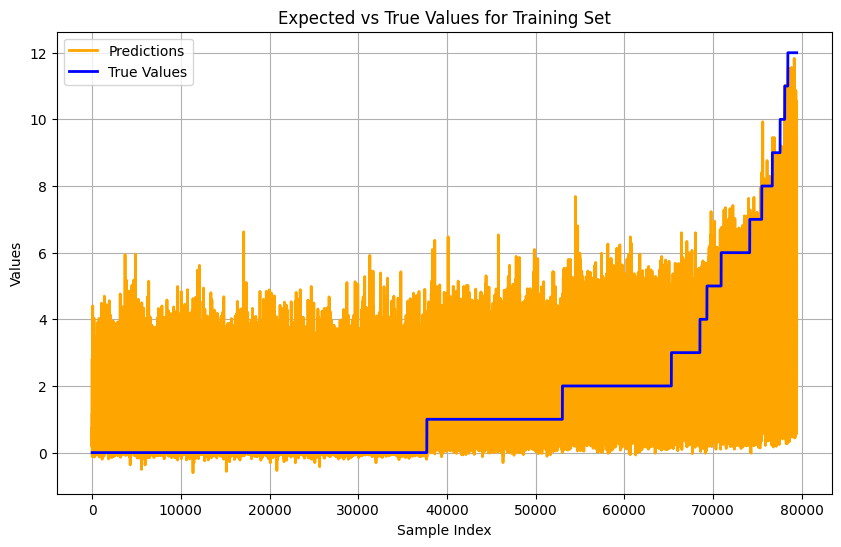

In [249]:
# Predict and evaluate
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_train)
sorted_y_train = y_train[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_train, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Training Set')
plt.legend()
plt.grid(True)
plt.show()

### Show results - Validation set

Mean Squared Error: 4.55


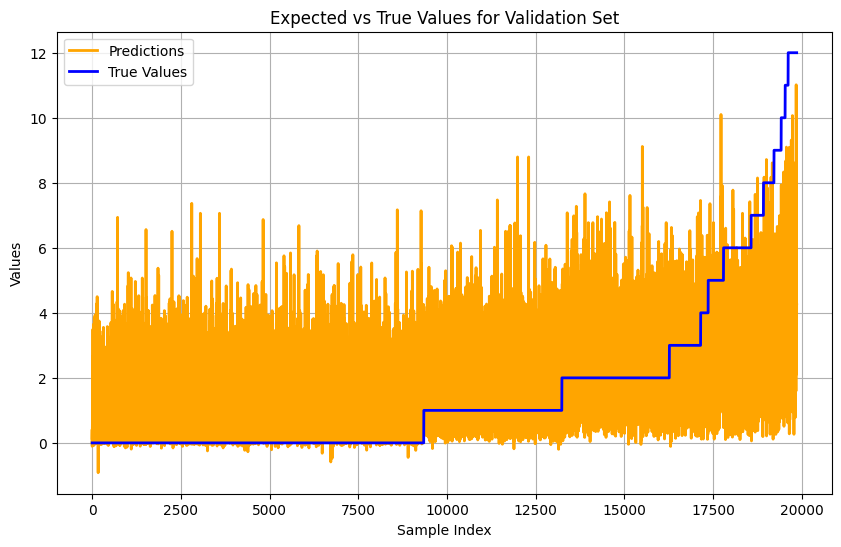

In [250]:
# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_val)
sorted_y_val = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_val, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions

### Prepare test data

In [108]:
# # URL for the FPL API
# url = "https://fantasy.premierleague.com/api/bootstrap-static/"

# # Make an HTTP GET request to fetch the data
# response = requests.get(url)

# if response.status_code == 200:
#     data = response.json()
#     print(data.keys())

#     # Save the data to a file
#     with open("data/overall_data.json", "w") as f:
#         json.dump(data, f)
# else:
#     print(f"Failed to retrieve data. Status code: {response.status_code}")

# Load the saved JSON data from the file
with open("data/overall_data.json", "r") as f:
    data = json.load(f)

In [109]:
# Extract data
events = data['events']
game_settings = data['game_settings']
phases = data['phases']
teams = data['teams']
total_players = data['total_players']
players = data['elements']
element_stats = data['element_stats']
element_types = data['element_types']

In [110]:
player_overall_stats = {}
for player in players:
    player_id = str(player['id'])
    player_overall_stats[player_id] = player

In [111]:
# Show players with highest xPoints for next gameweek
for player in players:
    if float(player['ep_next']) > 7:
        print(player['web_name'], player['ep_next'])

M.Salah 12.7
Gvardiol 7.3
B.Fernandes 8.5
Cunha 7.2


In [112]:
# player_stats = {}
# for player_id in player_overall_stats.keys():
# #     print(player_id)
#     url = f"https://fantasy.premierleague.com/api/element-summary/{player_id}/"
#     response = requests.get(url)
    
#     if response.status_code == 200:
#         # Get player stats for played gameweeks
#         player_history = response.json()['history']
#         for i in range(len(player_history)):
#             player_fixture = fixtures_data[str(player_history[i]['fixture'])]
#             if player_history[i]['was_home'] == True:
#                 player_history[i]['player_team'] = player_fixture['team_h']
#                 player_history[i]['team_goals'] = player_fixture['team_h_score']
#             else:
#                 player_history[i]['player_team'] = player_fixture['team_a']
#                 player_history[i]['team_goals'] = player_fixture['team_a_score']
#         player_history = {str(element['round']): element for element in player_history}
        
#         # Get player upcoming fixtures
#         player_fixtures = response.json()['fixtures']
#         player_fixtures = {str(element['event']): element for element in player_fixtures}
        
#         # Add to overall player stats dictionary
#         player_stats[player_id] = {'fixtures': player_fixtures, 'history': player_history}
    
#     else:
#         print(f"Failed to retrieve data. Status code: {response.status_code}")
        
# # Save the data to a file
# with open("data/player_data.json", "w") as f:
#     json.dump(player_stats, f)

# Load the saved JSON data from the file
with open("data/player_data.json", "r") as f:
    player_stats = json.load(f)

In [113]:
# Player mapping for several FPL names for one player
fpl_name_mapping = {
    'Adama Traoré Diarra': 'Adama Traoré',
    'André Filipe Tavares Gomes': 'André Tavares Gomes',
    'Arnaut Danjuma Groeneveld': 'Arnaut Danjuma',
    'Benjamin Chilwell': 'Ben Chilwell',
    'Benjamin White': 'Ben White',
    'Bernardo Mota Veiga de Carvalho e Silva': 'Bernardo Veiga de Carvalho e Silva',
    'Bruno Miguel Borges Fernandes': 'Bruno Borges Fernandes',
    'Cédric Alves Soares': 'Cédric Soares',
    'David de Gea': 'David De Gea Quintana',
    'Diogo Teixeira da Silva': 'Diogo Jota',
    'Emerson Aparecido Leite de Souza Junior': 'Emerson Leite de Souza Junior',
    'Emiliano Martínez Romero': 'Emiliano Martínez',
    'Gabriel Teodoro Martinelli Silva': 'Gabriel Martinelli Silva',
    'Héctor Junior Firpo Adames': 'Junior Firpo Adames',
    'Hee-Chan Hwang': 'Hwang Hee-Chan',
    'Hwang Hee-chan': 'Hwang Hee-Chan',
    'Heung-Min Son': 'Son Heung-Min',
    'Son Heung-min': 'Son Heung-Min',
    'Jeremy Sarmiento Morante': 'Jeremy Sarmiento',
    'João Pedro Cavaco Cancelo': 'João Cancelo',
    'Joseph Gomez': 'Joe Gomez',
    'Joseph Willock': 'Joe Willock',
    'Luis Sinisterra Lucumí': 'Luis Sinisterra',
    'Lyanco Evangelista Silveira Neves Vojnovic': 'Lyanco Silveira Neves Vojnovic',
    'Marc Cucurella Saseta': 'Marc Cucurella',
    'Mateo Kovačić': 'Mateo Kovacic',
    'Matthew Cash': 'Matty Cash',
    'Miguel Almirón Rejala': 'Miguel Almirón',
    'Mohamed Naser El Sayed Elneny': 'Mohamed Elneny',
    'Moisés Caicedo Corozo': 'Moisés Caicedo',
    'Pablo Fornals Malla': 'Pablo Fornals',
    'Rayan Ait Nouri': 'Rayan Aït-Nouri',
    'Ricardo Domingos Barbosa Pereira': 'Ricardo Barbosa Pereira',
    'Rúben Diogo da Silva Neves': 'Rúben da Silva Neves',
    'Rúben Santos Gato Alves Dias': 'Rúben Gato Alves Dias',
    'Sergi Canós Tenés': 'Sergi Canós',
    'Vladimir Coufal': 'Vladimír Coufal',   
}

In [114]:
id_dict = {}
name_to_id = {}
df_player_id = pd.read_csv('data/2024-25/player_idlist.csv')
for row in df_player_id.iloc:
    name = row['first_name'] + ' ' + row['second_name']
    mapped_name = fpl_name_mapping.get(name, name)
    id_dict[str(row['id'])] = mapped_name
    name_to_id[mapped_name] = str(row['id'])

### Create prediction data

In [65]:
next_gameweek = 12

X_test_games = []
eP_games = []
player_names_games = []

# Look at next 5 games
for i in range(5):
    
    X_test = []
    eP = []
    player_names = []
        
    for player_id in id_dict.keys():
        df_temp = df_all[df_all.name == id_dict[player_id]]
        
        # If player does not have at least 3 previous games then skip
        if len(df_temp) < 3:
            continue
            
        # If playerID is not in player_stats
        if not player_id in player_stats.keys():
            continue

        # Get player's next game
        next_game = player_stats[player_id]['fixtures'][str(next_gameweek+i)]
        
        # Get one-hot encoding for players team, opp team and home/away
        if next_game['is_home']:
            player_team = one_hot_encode_team(next_game['team_h'], 27)
            opponent_team = one_hot_encode_team(next_game['team_a'], 27)
            home_away = one_hot_encode_team(1, 2)
        else:
            player_team = one_hot_encode_team(next_game['team_a'], 27)
            opponent_team = one_hot_encode_team(next_game['team_h'], 27)
            home_away = one_hot_encode_team(0, 2)
            
        # Get position information of player
        position = one_hot_encode_team(df_temp.iloc[-1]['pos_id'], 4)
#         position = one_hot_encode_team(player_overall_stats[player_id]['element_type'], 4)
        
        # Combine next game stats
        combined_stats = np.concatenate([player_team, opponent_team, home_away, position])
        
        # Get expected points (y value)
        expected_points = float(player_overall_stats[player_id]['ep_next'])
        
        # Get player stats from his previous 3 games
        for j in range(1,4):
            row_temp = df_temp.iloc[-j]
            
            # Get home/away encoding
            home_away = one_hot_encode_team(row_temp['was_home'], 2)
            
            # Add player team goals and opponent team goals
            if row_temp.was_home:
                score = np.array(row_temp[['team_h_score', 'team_a_score']].astype(float).values)
            else:
                score = np.array(row_temp[['team_a_score','team_h_score']].astype(float).values)
            
            # Select the wanted stats and convert to float numpy array
            selected_stats = np.array(row_temp[keys_to_select].astype(float).values) 
                
            # Combine into one vector
            combined_stats = np.concatenate([combined_stats, home_away, score, selected_stats])
            
        # Append combined stats to X and points (y value) to y
        X_test.append(combined_stats)
        eP.append(expected_points)
        player_names.append(id_dict[player_id])
        
    # Convert to numpy arrays
    X_test = np.array(X_test)
    eP = np.array(eP)
    
    # Append to overall list
    X_test_games.append(X_test)
    eP_games.append(eP)
    player_names_games.append(player_names)

### Make predictions

Mean Squared Error: 1.92


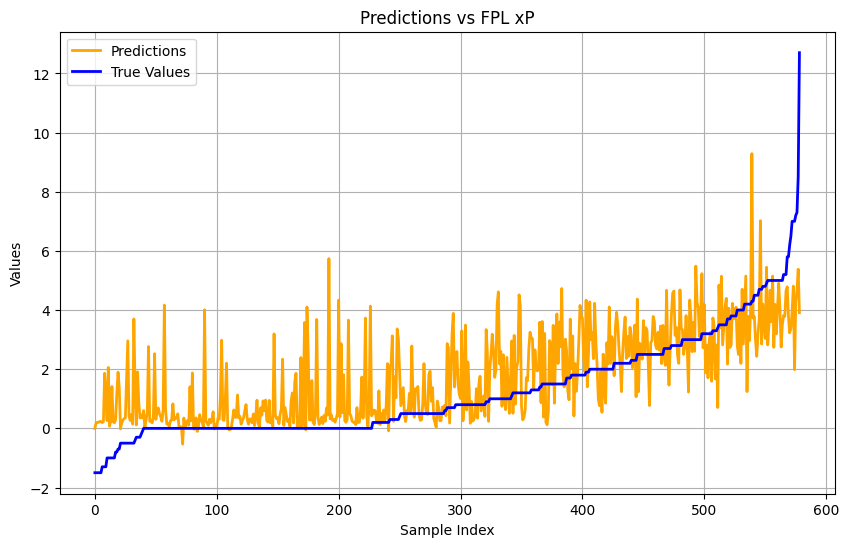

In [251]:
# Get test data
X_test = X_test_games[0]
X_test = scaler.transform(X_test)
y_test = eP_games[0]
player_ids_test = player_names_games[0]

# Make predictions on the test data
predictions = model.predict(X_test)
mse = mean_squared_error(eP_games[0], predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(eP_games[0])
sorted_ep = eP_games[0][sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_ep, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predictions vs FPL xP')
plt.legend()
plt.grid(True)
plt.show()

In [252]:
predictions_all = []
for i in range(5):
    # Get test data
    X_test = X_test_games[i]
    X_test = scaler.transform(X_test)

    # Make predictions on the test data
    predictions_part = model.predict(X_test)
    predictions_all.append(predictions_part)
    
predictions_all = np.array(predictions_all)
predictions_sum = np.sum(predictions_all, axis=0)

# Highest predictions (top 10)
top_10_indices = np.argsort(predictions.flatten())[-10:]
top_10_indices = top_10_indices[np.argsort(predictions.flatten()[top_10_indices])[::-1]]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, player_ids_test[i], f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

# Define position mapping
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Flatten the predictions array for easier sorting
# predictions_flat = predictions.flatten()

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple (predicted_score, actual_score, web_name)
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    
    # Append to the respective position list
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[0], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players:
+------+--------------------------+-----------------+--------+------------------+-------------------+
| Rank |          Player          | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+--------------------------+-----------------+--------+------------------+-------------------+
|  1   |      Erling Haaland      |      9.29       |  4.30  |      36.21       |        100        |
|  2   |       Bryan Mbeumo       |      7.02       |  4.70  |      34.32       |        75         |
|  3   |       Deniz Undav        |      5.74       |  0.00  |      24.56       |         0         |
|  4   |      Son Heung-Min       |      5.48       |  3.00  |      28.05       |        100        |
|  5   |       Yoane Wissa        |      5.45       |  4.90  |      27.01       |        75         |
|  6   |  Bruno Borges Fernandes  |      5.38       |  8.50  |      25.43       |        100        |
|  7   |       Bukayo Saka        |      5.23   

In [253]:
predictions_all = []
for i in range(5):
    # Get test data
    X_test = X_test_games[i]
    X_test = scaler.transform(X_test)

    # Make predictions on the test data
    predictions_part = model.predict(X_test)
    predictions_all.append(predictions_part)
    
predictions_all = np.array(predictions_all)
predictions_sum = np.sum(predictions_all, axis=0)

# Highest predictions (top 10)
top_10_indices = np.argsort(predictions_sum.flatten())[-10:]
top_10_indices = top_10_indices[np.argsort(predictions_sum.flatten()[top_10_indices])[::-1]]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, player_ids_test[i], f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players, sorted by sum of next 5 games:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}

# Define position mapping
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Flatten the predictions array for easier sorting
# predictions_flat = predictions.flatten()

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple (predicted_score, actual_score, web_name)
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    
    # Append to the respective position list
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[3], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players, sorted by sum of next 5 games:
+------+--------------------------+-----------------+--------+------------------+-------------------+
| Rank |          Player          | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+--------------------------+-----------------+--------+------------------+-------------------+
|  1   |      Erling Haaland      |      9.29       |  4.30  |      36.21       |        100        |
|  2   |       Bryan Mbeumo       |      7.02       |  4.70  |      34.32       |        75         |
|  3   |      Son Heung-Min       |      5.48       |  3.00  |      28.05       |        100        |
|  4   |       Cole Palmer        |      5.14       |  3.50  |      27.11       |        75         |
|  5   |       Yoane Wissa        |      5.45       |  4.90  |      27.01       |        75         |
|  6   |     Łukasz Fabiański     |      4.84       |  3.50  |      26.51       |       None        |
|  7   | Dominic 

### Load my team data

In [254]:
user_id = 10581845
url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{11}/picks/'

response = requests.get(url)
data = response.json()

In [255]:
# Prepare a mapping of positions
position_mapping = {1: 'Goalkeeper', 2: 'Defender', 3: 'Midfielder', 4: 'Forward'}

# Prepare data for each position
grouped_data = {'Goalkeeper': [], 'Defender': [], 'Midfielder': [], 'Forward': []}

# Populate grouped data based on position
for player in data['picks']:
    player_name = id_dict[str(player["element"])]
    prediction = predictions[player_ids_test.index(player_name)]
    sum5 = predictions_sum[player_ids_test.index(player_name)]
    fpl_xp = y_test[player_ids_test.index(player_name)]
    player_position = position_mapping[player_overall_stats[str(player['element'])]['element_type']]
    grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{fpl_xp:.2f}', f"{sum5:.2f}"])

# Display each group in separate tables
for position, players in grouped_data.items():
    print(f"\nPosition: {position}")
    print(tabulate(players, headers=['Player Name', 'Predicted Score', "FPL xP", 'Sum next 5 games'], tablefmt="pretty"))



Position: Goalkeeper
+-------------------+-----------------+--------+------------------+
|    Player Name    | Predicted Score | FPL xP | Sum next 5 games |
+-------------------+-----------------+--------+------------------+
| David Raya Martin |      3.78       |  2.50  |      17.47       |
| Łukasz Fabiański  |      4.84       |  3.50  |      26.51       |
+-------------------+-----------------+--------+------------------+

Position: Defender
+------------------------------+-----------------+--------+------------------+
|         Player Name          | Predicted Score | FPL xP | Sum next 5 games |
+------------------------------+-----------------+--------+------------------+
| Gabriel dos Santos Magalhães |      3.61       |  2.50  |      16.33       |
|       Rayan Aït-Nouri        |      2.82       |  3.50  |      16.22       |
|        Ethan Pinnock         |      3.41       |  2.50  |      18.09       |
|         Jonny Evans          |      1.34       |  0.50  |       7.00      

In [136]:
# Get unique values and their counts
unique_values, counts = np.unique(y, return_counts=True)

# Combine the results into a dictionary for better readability
value_counts = dict(zip(unique_values, counts))

value_counts